## Problem 1 — Merton’s Jump–Diffusion Process

Write a program to implement Merton’s jump–diffusion process. Suggested parameters:
- T = 300, dt = 1, λ = 0.01, S0 = 5, μ = 0.01, σ = 0.02

Y may adjust parameters if the plot isn’t informative. Report:
- Plots of several generated paths
- The times at which jumps occur (per path)


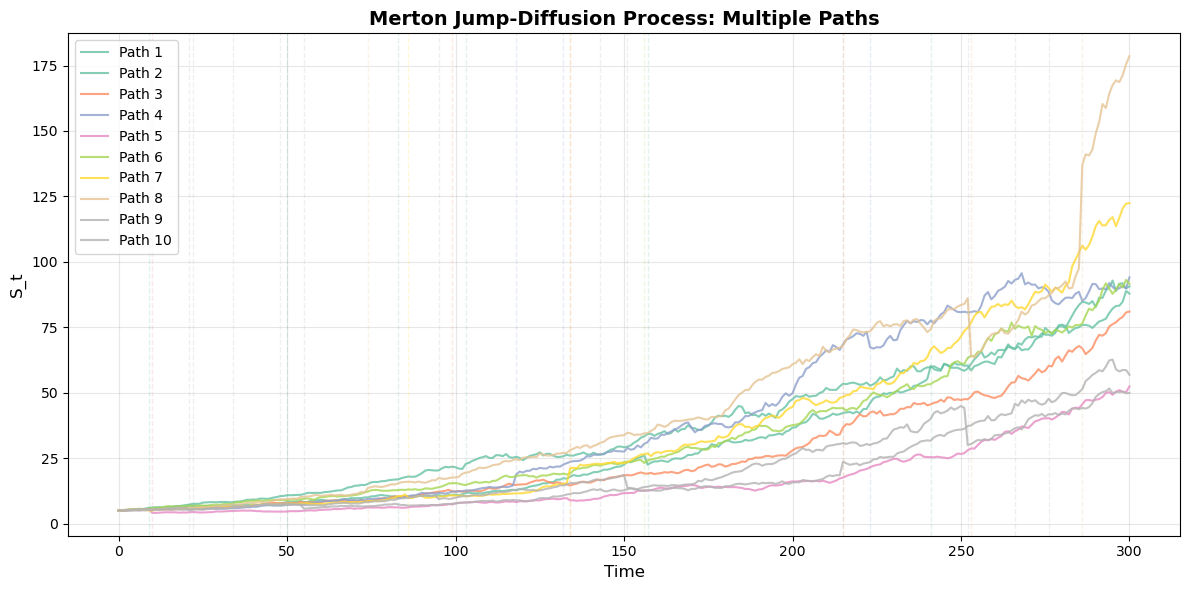

Jump Times by Path
Path 1: 1 jump(s) at times [103]
Path 2: 5 jump(s) at times [9, 50, 83, 157, 241]
Path 3: 2 jump(s) at times [99, 215]
Path 4: 3 jump(s) at times [118, 132, 223]
Path 5: 2 jump(s) at times [10, 134]
Path 6: 1 jump(s) at times [156]
Path 7: 2 jump(s) at times [86, 134]
Path 8: 3 jump(s) at times [74, 253, 286]
Path 9: 8 jump(s) at times [21, 22, 34, 48, 55, 215, 266, 276]
Path 10: 4 jump(s) at times [95, 143, 151, 252]
Expected number of jumps: λ × T = 0.01 × 300 = 3.0
Actual average across 10 paths: 3.10


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 300         
dt = 1.0         
lam = 0.01      
S0 = 5.0
mu = 0.01
sigma = 0.02

# jump size distribution parameters
mu_J = -0.1      # mean of log(1 + J)
sigma_J = 0.2    # std of log(1 + J)

N_steps = int(T / dt)
t_grid = np.arange(N_steps + 1)

# Number of paths to generate
n_paths = 10

# Store all paths and their jump times
all_paths = []
all_jump_times = []

rng = np.random.default_rng(123)

# Generate multiple paths
for path_num in range(n_paths):
    S = np.zeros(N_steps + 1)
    S[0] = S0
    jump_times = []
    
    for k in range(N_steps):
        # Brownian increment
        dW = np.sqrt(dt) * rng.normal()

        # Poisson jumps: number of jumps in [t, t+dt]
        N_t = rng.poisson(lam * dt)

        # total jump factor over this step
        if N_t > 0:
            # log(1+J) ~ N(mu_J, sigma_J^2)
            Y = rng.normal(mu_J, sigma_J, size=N_t)
            J_factor = np.exp(Y).prod()
            jump_times.append(t_grid[k+1])
        else:
            J_factor = 1.0

        # Merton SDE step (Euler)
        S[k+1] = S[k] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW) * J_factor

    all_paths.append(S)
    all_jump_times.append(jump_times)

# Plot all paths
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Set2(np.linspace(0, 1, n_paths))

for path_num in range(n_paths):
    ax.plot(t_grid, all_paths[path_num], label=f"Path {path_num + 1}", 
            color=colors[path_num], alpha=0.8, linewidth=1.5)
    
    # Mark jump times for this path with subtle vertical lines
    for jt in all_jump_times[path_num]:
        ax.axvline(jt, color=colors[path_num], alpha=0.2, linestyle='--', linewidth=1)

ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("S_t", fontsize=12)
ax.set_title("Merton Jump-Diffusion Process: Multiple Paths", fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print jump times for each path
print("=" * 60)
print("Jump Times by Path")
print("=" * 60)
for path_num in range(n_paths):
    n_jumps = len(all_jump_times[path_num])
    print(f"Path {path_num + 1}: {n_jumps} jump(s) at times {all_jump_times[path_num]}")

print("=" * 60)
print(f"Expected number of jumps: λ × T = {lam} × {T} = {lam * T:.1f}")
print(f"Actual average across {n_paths} paths: {np.mean([len(jt) for jt in all_jump_times]):.2f}")
print("=" * 60)


## Problem 2 — MLE for Uniform[0, θ], Bootstrap, and Probabilities
Suppose X_1, …, X_50 are i.i.d. Uniform[0, θ].

(a) Find the MLE for θ and compute the distribution of the MLE.


### (a) MLE for $\theta$ and its distribution

Assume $X_1, \dots, X_n \overset{iid}{\sim} \text{Uniform}[0,\theta]$. The joint density of the sample is
$$
f(x_1,\dots,x_n;\theta)
= \prod_{i=1}^n \frac{1}{\theta} \mathbf{1}_{[0,\theta]}(x_i)
= \theta^{-n} \mathbf{1}\{0 \le x_{(1)}, x_{(n)} \le \theta\},
$$
where $x_{(1)} = \min_i x_i$ and $x_{(n)} = \max_i x_i$.

For fixed observed data, this likelihood is
- zero if $\theta < x_{(n)}$, because at least one observation would lie outside $[0,\theta]$, and  
- equal to $\theta^{-n}$ for all $\theta \ge x_{(n)}$.

On the interval $[x_{(n)}, \infty)$, the function $\theta^{-n}$ is strictly decreasing in $\theta$. Therefore, the likelihood is maximized by choosing the smallest admissible value of $\theta$, namely $\theta = x_{(n)}$. Hence the maximum likelihood estimator is
$$
\hat\theta = X_{(n)} = \max\{X_1,\dots,X_n\}.
$$

To find the distribution of $\hat\theta$, note that
$$
P(\hat\theta \le x)
= P(X_{(n)} \le x)
= P(X_1 \le x, \dots, X_n \le x)
= \prod_{i=1}^n P(X_i \le x)
= \left(\frac{x}{\theta}\right)^n, \quad 0 \le x \le \theta,
$$
since each $X_i$ is Uniform $[0,\theta]$ and $P(X_i \le x) = x/\theta$ for $x \in [0,\theta]$.

Differentiating this cdf with respect to $x$ gives the pdf of $\hat\theta$:
$$
f_{\hat\theta}(x)
= \frac{d}{dx} \left(\frac{x}{\theta}\right)^n
= \frac{n x^{n-1}}{\theta^n}, \quad 0 \le x \le \theta.
$$
Equivalently, the scaled estimator $\hat\theta / \theta$ has a $\text{Beta}(n,1)$ distribution.



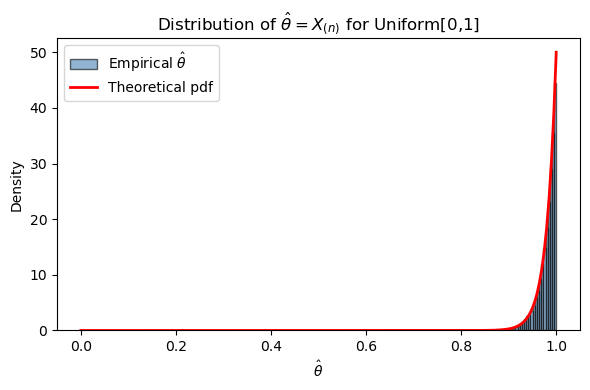

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, uniform

# Settings
np.random.seed(42)
theta_true = 1.0
n = 50
n_rep = 10000  # number of Monte Carlo replications

# Simulate MLEs
theta_hats = np.empty(n_rep)
for r in range(n_rep):
    sample = np.random.uniform(0, theta_true, size=n)
    theta_hats[r] = np.max(sample)

plt.figure(figsize=(6, 4))
plt.hist(theta_hats, bins=40, density=True, alpha=0.6, color='steelblue', edgecolor='k', label=r'Empirical $\hat\theta$')

x_grid = np.linspace(0, theta_true, 200)
f_theta_hat = n * x_grid**(n - 1) / theta_true**n
plt.plot(x_grid, f_theta_hat, 'r-', lw=2, label='Theoretical pdf')

plt.xlabel(r'$\hat\theta$')
plt.ylabel('Density')
plt.title(r'Distribution of $\hat\theta = X_{(n)}$ for Uniform[0,1]')
plt.legend()
plt.tight_layout()
plt.show()


(b) Generate your own observations x₁, …, xₙ (with only one maximum and θ = 1), and based on them plot a histogram of the bootstrap samples (N = 1000). Compare the distribution of the MLE and this histogram.

Observed MLE (theta_hat): 0.9856
Empirical P(theta* = theta_hat | data): 0.6360
Theoretical P(theta* = theta_hat | data): 0.6358


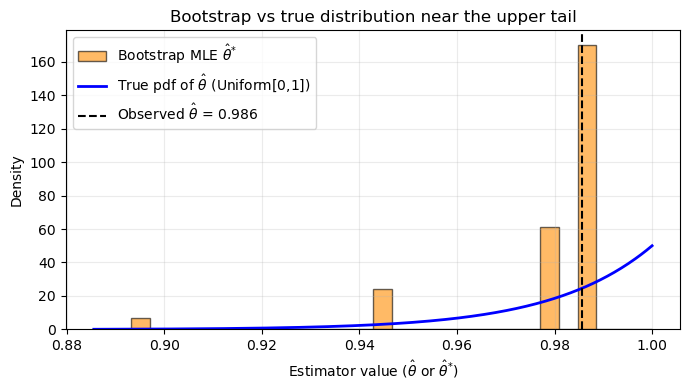

In [20]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

theta_true = 1.0
n = 50
N_boot = 1000

x = np.random.uniform(0, theta_true, size=n)
theta_hat = np.max(x)

theta_boot = np.empty(N_boot)
for b in range(N_boot):
    idx = np.random.randint(0, n, size=n)
    x_star = x[idx]
    theta_boot[b] = np.max(x_star)

p_equal_empirical = np.mean(np.isclose(theta_boot, theta_hat))
p_equal_theoretical = 1 - (1 - 1/n)**n

print(f"Observed MLE (theta_hat): {theta_hat:.4f}")
print(f"Empirical P(theta* = theta_hat | data): {p_equal_empirical:.4f}")
print(f"Theoretical P(theta* = theta_hat | data): {p_equal_theoretical:.4f}")

fig, ax = plt.subplots(figsize=(7, 4))

x_min_zoom = max(0, theta_hat - 0.1)
x_max_zoom = 1.0

ax.hist(
    theta_boot,
    bins=30,
    range=(x_min_zoom, x_max_zoom),
    density=True,
    alpha=0.6,
    color='darkorange',
    edgecolor='k',
    label=r'Bootstrap MLE $\hat\theta^{*}$'
)

x_grid_zoom = np.linspace(x_min_zoom, x_max_zoom, 400)
f_true_zoom = n * x_grid_zoom**(n - 1)
ax.plot(
    x_grid_zoom,
    f_true_zoom,
    'b-',
    lw=2,
    label=r'True pdf of $\hat\theta$ (Uniform[0,1])'
)

ax.axvline(
    theta_hat,
    color='k',
    linestyle='--',
    lw=1.5,
    label=rf'Observed $\hat\theta$ = {theta_hat:.3f}'
)

ax.set_xlabel(r'Estimator value ($\hat\theta$ or $\hat\theta^{*}$)')
ax.set_ylabel('Density')
ax.set_title('Bootstrap vs true distribution near the upper tail')
ax.legend(loc='upper left')
ax.grid(alpha=0.25)
fig.tight_layout()
plt.show()




(c) This example shows that bootstrap does poorly. In fact, P(θ̂ = 1 | θ = 1) = 0 but P(θ* = θ | data) ≈ 0.636. Prove these two statements.

Hint for (c): P(θ* = θ | data) = 1 − (1 − 1/n)^n. For illustration, use n = 50.


Under the true model $X_1,\dots,X_n \overset{iid}{\sim} \text{Uniform}[0,1]$, the distribution is continuous, so for any fixed point $a$ we have $P(X_i = a) = 0$.  
In particular, the MLE is $\hat\theta = \max_i X_i$, and
$$
P(\hat\theta = 1) = P(\max_i X_i = 1) = 0,
$$
because this would require at least one $X_i$ to be exactly 1, an event of probability 0.

Now condition on an observed sample $\{x_1,\dots,x_n\}$ with a unique maximum $x_{(n)}$.  
In a nonparametric bootstrap sample of size $n$, each resampled observation is drawn from $\{x_1,\dots,x_n\}$ with probability $1/n$ for each point, so the probability that a single draw is *not* the maximum $x_{(n)}$ is $1 - 1/n$.  
The probability that none of the $n$ bootstrap draws equals $x_{(n)}$ is therefore $(1 - 1/n)^n$, hence
$$
P(\hat\theta^* = \hat\theta \mid \text{data})
= P(\text{bootstrap sample contains } x_{(n)} \text{ at least once})
= 1 - (1 - 1/n)^n.
$$
For $n=50$, this gives
$$
P(\hat\theta^* = \hat\theta \mid \text{data})
= 1 - (49/50)^{50} \approx 0.636.
$$

Thus, under the true continuous model, $P(\hat\theta = 1) = 0$, but under the bootstrap (conditional on the data) the probability that the bootstrap MLE equals the observed MLE is about $0.636$.  
This mismatch near the boundary shows that the nonparametric bootstrap provides a poor approximation to the sampling distribution of the MLE for the Uniform$[0,\theta]$ endpoint.
